# PyKOALA Data Reduction Sequence (Science data)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from astropy import units as u
from pykoala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")

# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.18.3+92.g531832f.dirty


In [3]:
from pykoala.instruments.koala_ifu import koala_rss
from pykoala.corrections.atmospheric_corrections import AtmosphericExtCorrection, ADRCorrection
from pykoala.corrections.throughput import Throughput, ThroughputCorrection
from pykoala.cubing import CubeInterpolator, build_wcs
from pykoala.plotting.utils import qc_cube

atm_ext_corr = AtmosphericExtCorrection.from_text_file(
    AtmosphericExtCorrection.default_extinction)

[pykoala.correction.AtmosphericExtinction] 2025/10/10 13:56|INFO> Initialising correction


### Throughput correction

In [4]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput_corr = ThroughputCorrection.from_rss(flat_rss, clear_nan=True, medfilt=10)

[pykoala] 2025/10/10 13:56|INFO> 
> Reading KOALA RSS file combined_skyflat_red.fits
[pykoala] 2025/10/10 13:56|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/10/10 13:56|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
Applying median filter (size=10 px)


### Telluric correction

We will use the correction function derived during the standard stars reduction sequence.

In [5]:
from pykoala.corrections.sky import TelluricCorrection

telluric_corr = TelluricCorrection.from_text_file('products/telluric_correction_red.dat')

[pykoala] 2025/10/10 13:56|INFO> Initialising telluric correction from text file


## Load the science data

[pykoala] 2025/10/10 13:56|INFO> 
> Reading KOALA RSS file 27feb20034red.fits
[pykoala] 2025/10/10 13:56|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/10/10 13:56|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala.correction.AtmosphericExtinction] 2025/10/10 13:56|INFO> Applying model-based extinction correction toData Container (1.03 airmass)
[pykoala.correction.TelluricCorretion] 2025/10/10 13:56|INFO> Applying telluric correction
[pykoala] 2025/10/10 13:56|INFO> 
> Reading KOALA RSS file 27feb20035red.fits
[pykoala] 2025/10/10 13:56|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/10/10 13:56|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala.correction.AtmosphericExtinction] 2025/10/10 13:56|INFO> Applying model-based extinction correction toData Container (1.02 airmass)
[pykoala.co

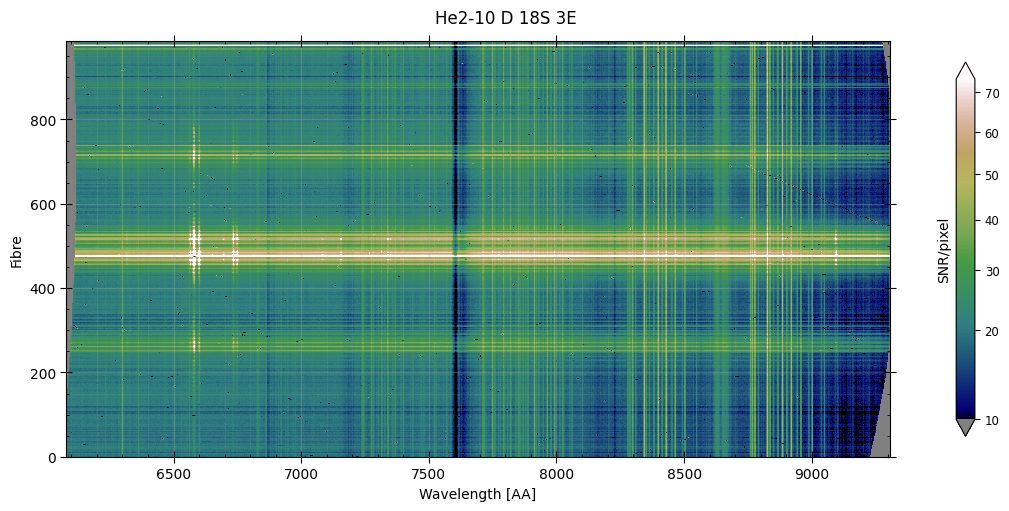

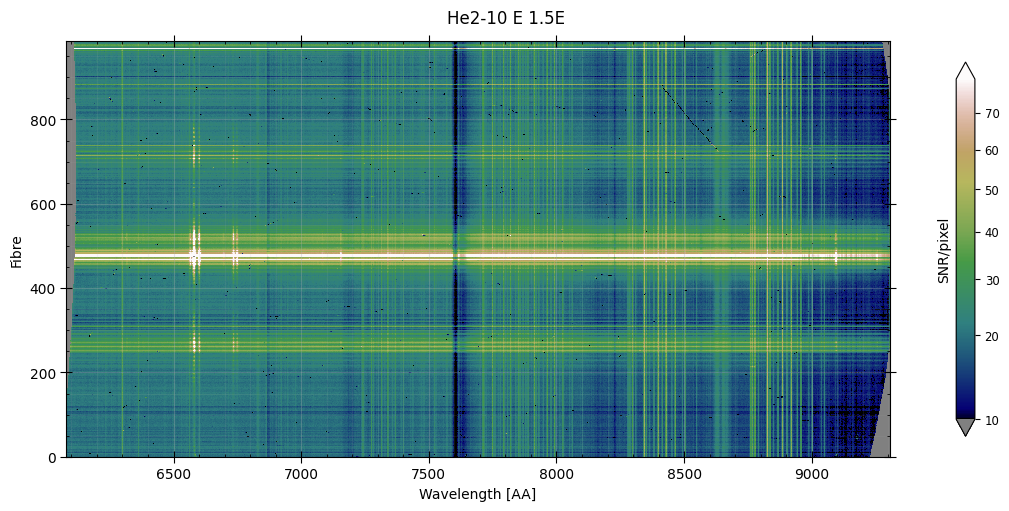

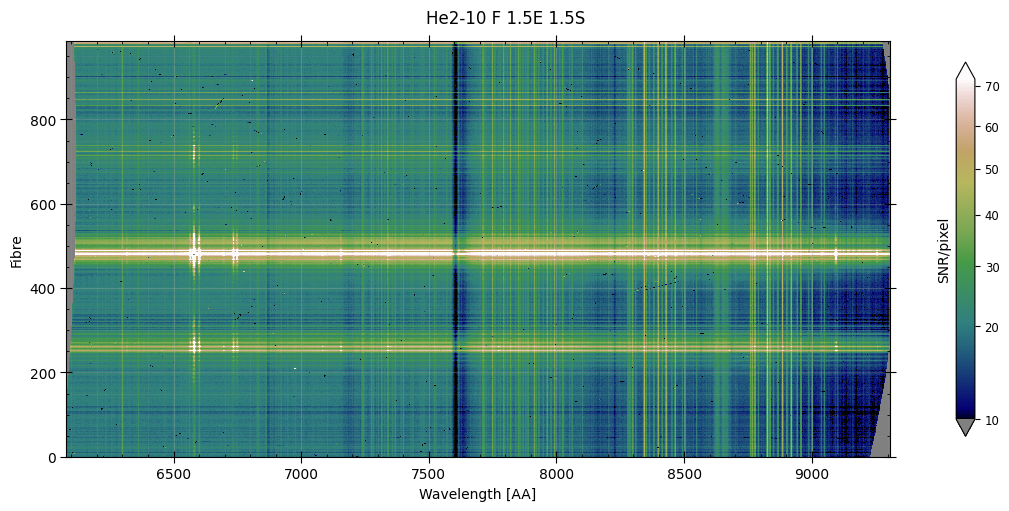

In [6]:
sci_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'
path_to_data = 'data'

adr_set = []

#for i in [31, 32, 33]:
for i in [34, 35, 36]:
    filename = f"data/27feb200{i}red.fits"
    rss = koala_rss(filename)

    rss = throughput_corr.apply(rss)
    rss = atm_ext_corr.apply(rss)
    rss = telluric_corr.apply(rss)
    # Telluric
    # Sky
    adr = ADRCorrection(max_adr=0.5*u.arcsec,
                        pol_deg=2, n_com_powers=4, clip_sigma=3.0)
    adr.estimate(rss, plot=False)
    rss = adr.apply(rss, copy=False)
    adr_set.append([rss.info["adr_offsets"]["dra_arcsec"],
                    rss.info["adr_offsets"]["ddec_arcsec"]])
    sci_rss.append(rss)

    rss.plot_rss_image(rss.snr, data_label="SNR/pixel")

## Astrometry Corrections and Registration

### Image Cross-correlation

The most sofisticated method to perform the registration of extended sources included in pyKOALA is based on the cross-correlation of two images.
### Centroid finding

A simple approach to find the offset between the different RSS is to find the center of light of the images (assuming that they contain the same sources).

In [8]:
from pykoala.corrections.astrometry import AstrometryCorrection, register_dataset_crosscorr

offsets, fig = register_dataset_crosscorr(sci_rss, qc_plot=True)
for offset, rss in zip(offsets, sci_rss):
    astrom_corr = AstrometryCorrection(offset)
    rss = astrom_corr.apply(rss)

[pykoala] 2025/10/10 13:58|INFO> [Xcorr] Building white images
[pykoala] 2025/10/10 13:58|INFO> Combined footprint center: 129.0627 deg, -26.4127 deg
[pykoala] 2025/10/10 13:58|INFO> Combined footprint Fov: 0.82 arcmin, 0.43 arcmin (arcmin)
[pykoala] 2025/10/10 13:58|INFO> Combined footprint wavelength range: 6081.0 Angstrom, 9305.4 Angstrom (AA)
[pykoala] 2025/10/10 13:58|INFO> WCS array shape: (2047, 99, 52) [wave, ra, dec]
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Using input WCS
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Initialising GaussianKernel
 Scale: 0.5 arcsec (pixels)
 Truncation radius: 3.0 (1.5 arcsec px)
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Initialising new Cube with dimensions: (2047, 52, 99)
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Output Cube units: adu / s
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Cubing input RSS set
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Interpolating RSS to cube
[pykoala.CubeInterp] 2025/10/10 13:58|INFO> Fibres will be interpo

<Figure size 640x480 with 0 Axes>

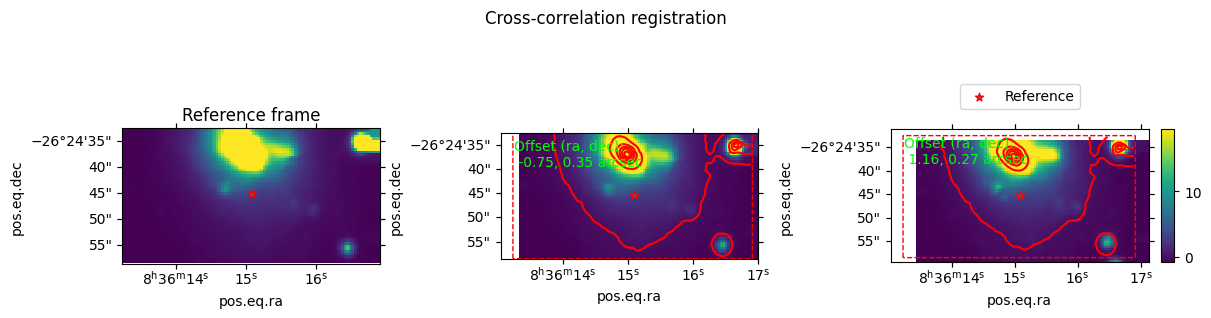

In [9]:
fig

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- The desired dimensions of the cube expressed as a 2-element tuple, corresponding to (ra, dec) in arcseconds.
- The pixel size of the cube in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)].
- Additional information to be included in *cube_info*

In [10]:
datacube_shape = (sci_rss[0].wavelength.size, 40, 60)
ref_position = (sci_rss[0].wavelength[0],
                np.mean(sci_rss[0].info['fib_ra']),
                np.mean(sci_rss[0].info['fib_dec']))  # (deg, deg)
spatial_pixel_size = 1.0 * u.arcsec
spectral_pixel_size = sci_rss[0].wavelength[1] - sci_rss[0].wavelength[0]  # (angstrom)

print(f"Creating a WCS with\n position: {ref_position}\n Spatial pixel size: {spatial_pixel_size}\n Spectral pixel size: {spectral_pixel_size}")

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

interpolator = CubeInterpolator(rss_set=sci_rss, wcs=wcs, adr_set=adr_set,
                                kernel_scale=1.0,
                                cube_info=dict(
                                    name=rss.info['name'].split(' ')[0]))
cube = interpolator.build_cube()


Creating a WCS with
 position: (<Quantity 6080.9588623 Angstrom>, <Quantity 129.06270331 deg>, <Quantity -26.41271784 deg>)
 Spatial pixel size: 1.0 arcsec
 Spectral pixel size: 1.575182312339166 Angstrom
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Using input WCS
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Initialising GaussianKernel
 Scale: 1.0 arcsec (pixels)
 Truncation radius: 3.0 (3.0 arcsec px)
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Initialising new Cube with dimensions: (2048, 60, 40)
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Output Cube units: adu / s
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Cubing input RSS set
[pykoala.CubeInterp] 2025/10/10 14:22|INFO> Interpolating RSS to cube
[pykoala.CubeInterp] 2025/10/10 14:23|INFO> Interpolating RSS to cube
[pykoala.CubeInterp] 2025/10/10 14:23|INFO> Interpolating RSS to cube
[pykoala.CubeInterp] 2025/10/10 14:23|INFO> Stacking individual cubes using mad_clipping


## Sky substraction

[pykoala] 2025/10/10 14:23|INFO> Creating SkyModel from input Data Container
[pykoala] 2025/10/10 14:23|INFO> 2400 sky fibres found below 5.1575 (sky flux = 0.4867) adu / s
[pykoala] 2025/10/10 14:23|INFO> Pre-estimating background using all data
[pykoala] 2025/10/10 14:23|INFO> Applying sigma-clipping mask (n-sigma=3)
[pykoala] 2025/10/10 14:23|INFO> Applying the mad estimator to 2400 sky fibres
[pykoala.correction.SkyCorrection] 2025/10/10 14:23|INFO> Applying sky subtraction


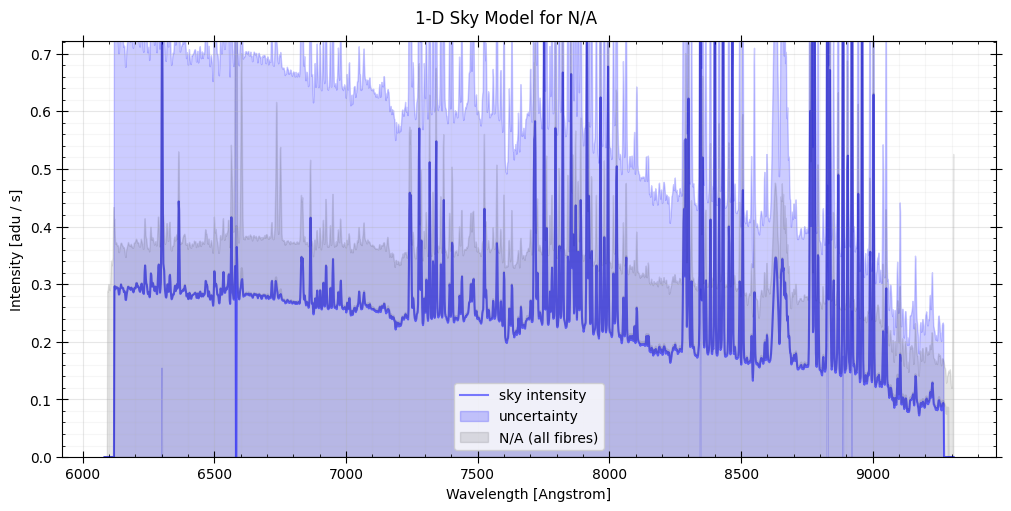

In [11]:
import pykoala.corrections.sky as sky
import importlib
importlib.reload(sky)

skymodel = sky.SkyFromObject(cube, bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
skycorrection = sky.SkySubsCorrection(skymodel)
cube, _ = skycorrection.apply(cube)

[pykoala] 2025/10/10 14:23|INFO> [QCPLOT] Cube QC plot for: N/A


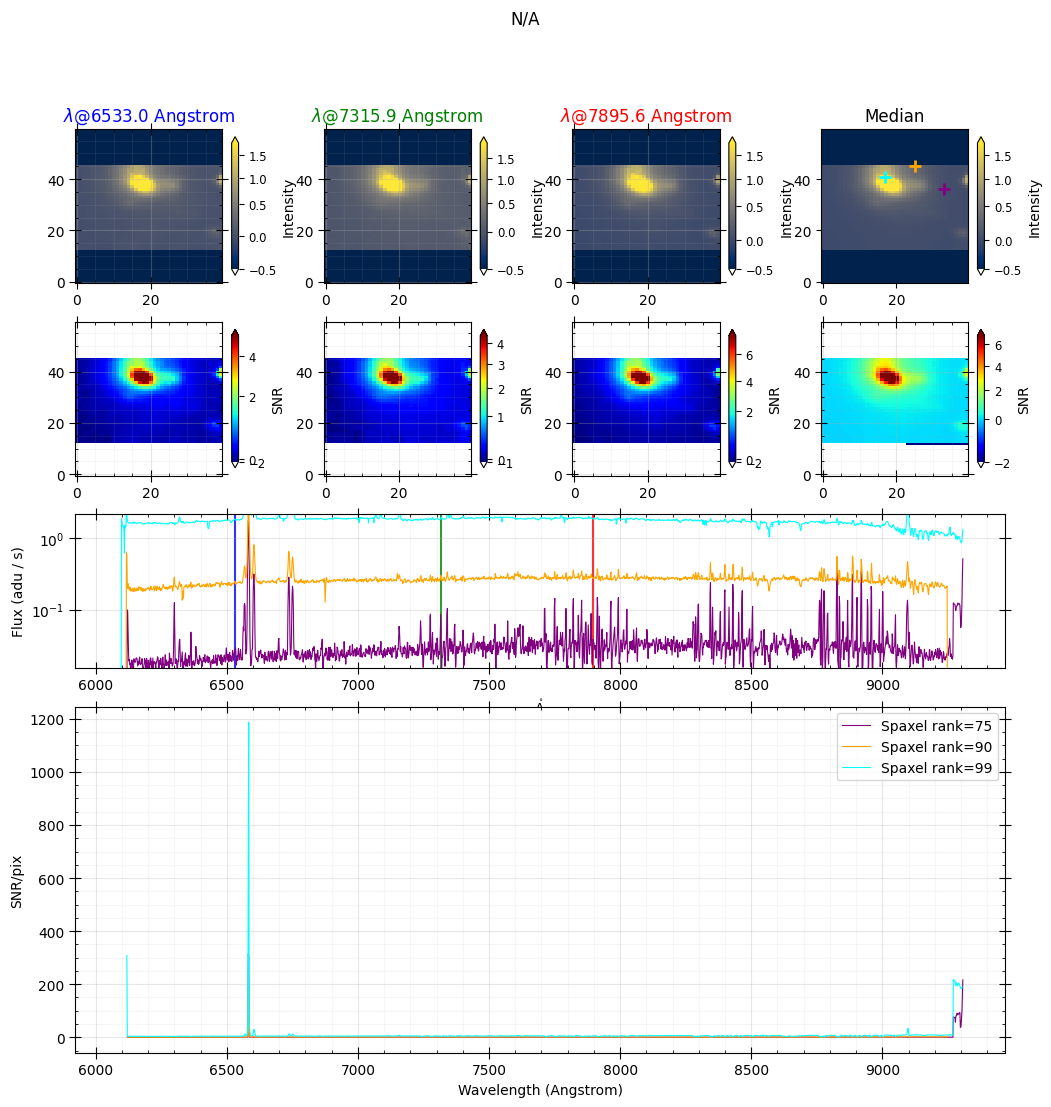

In [12]:
qc_cube(cube)

## Absolute flux calibration

[pykoala.correction.FluxCalibration] 2025/10/10 14:24|INFO> Initialising Flux Calibration (Spectral Throughput)


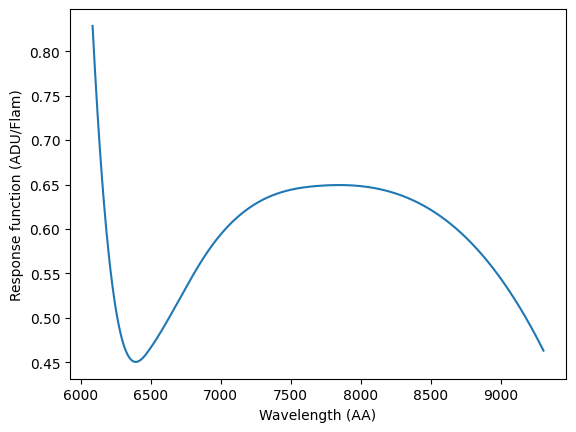

In [13]:
from pykoala.corrections.flux_calibration import FluxCalibration

fcal = FluxCalibration.from_text_file('products/response_HILT600_transfer_function.dat')

plt.figure()
plt.plot(fcal.response_wavelength, fcal.response)
plt.xlabel("Wavelength (AA)")
plt.ylabel("Response function (ADU/Flam)")
plt.show()

cube = fcal.apply(cube)

[pykoala] 2025/10/10 14:24|INFO> [QCPLOT] Cube QC plot for: N/A


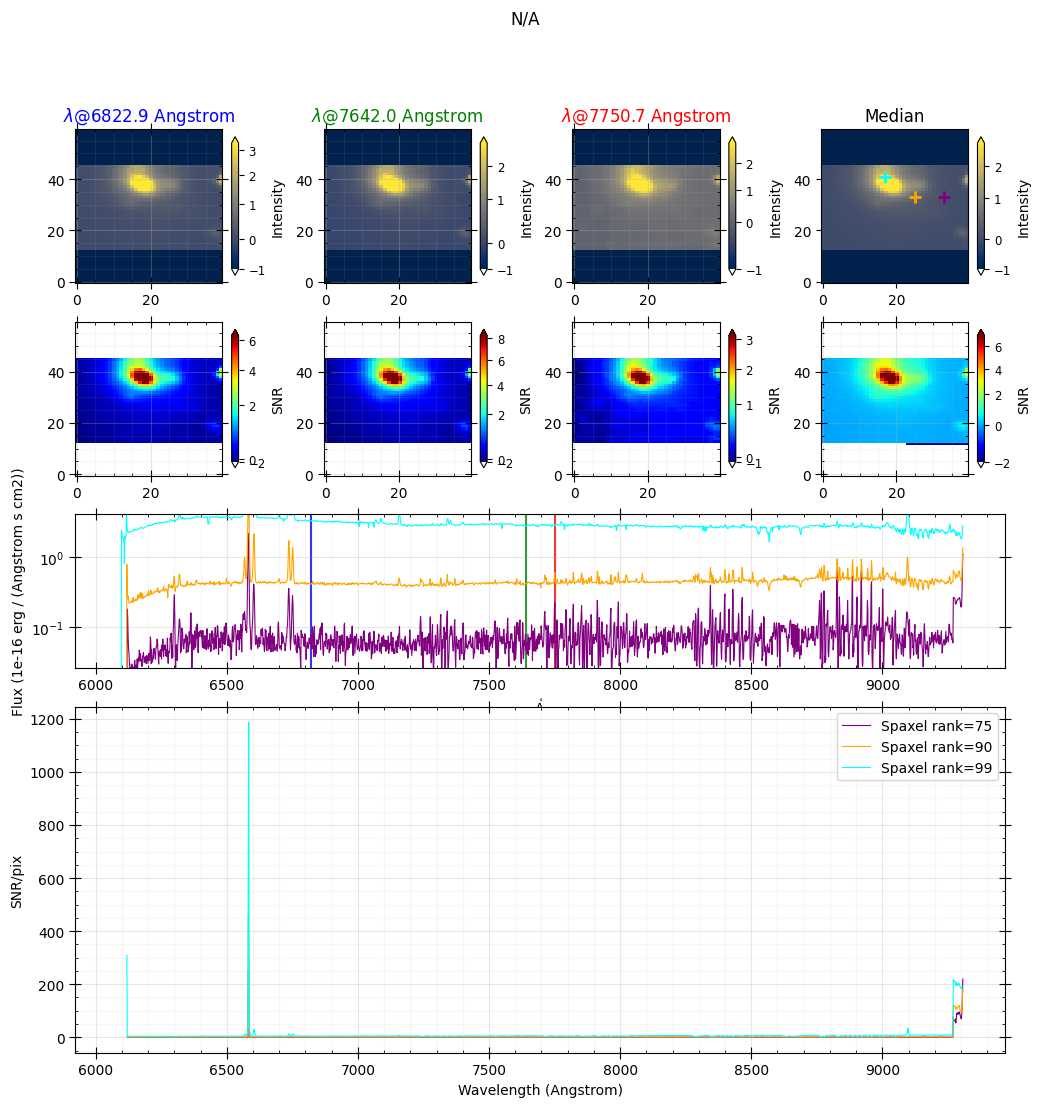

In [14]:
fig = qc_cube(cube)
plt.show(plt.figure(fig))


In [15]:
# Save the data cube
cube.to_fits("products/Henize_2-10_cube_no_sky.fits.gz", overwrite=True)

[pykoala.pykoala.cube] 2025/10/10 14:24|INFO> File saved as products/Henize_2-10_cube_no_sky.fits.gz
